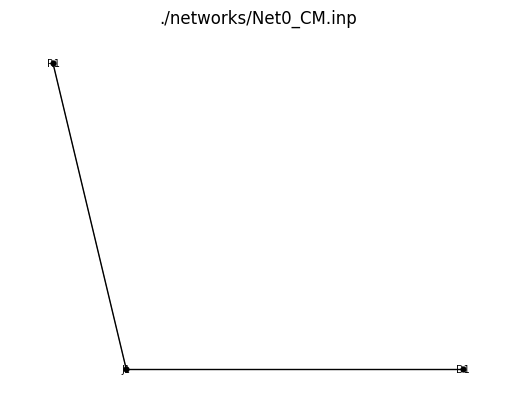

<Axes: title={'center': './networks/Net0_CM.inp'}>

In [51]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
inp_file = './networks/Net0_CM.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

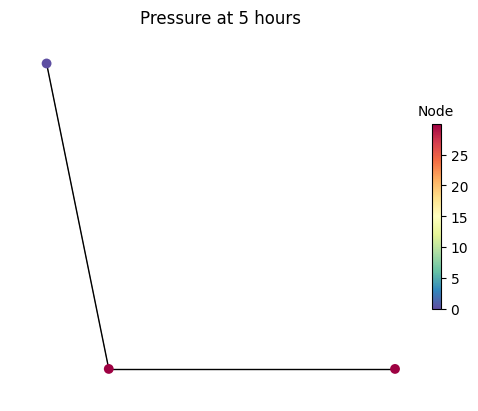

<Axes: title={'center': 'Pressure at 5 hours'}>

In [52]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [53]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 29.994, 29.988], dtype=float32)

# Run with QUBO solver

In [54]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (4./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

nqbit = 7
step = (200/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

In [55]:
from wntr_quantum.design.qubo_pipe_diam import QUBODesignPipeDiameter 
pipe_diameters = [250, 500, 1000]
designer = QUBODesignPipeDiameter(wn, flow_encoding, head_encoding, 
                                  pipe_diameters, head_lower_bound=95,
                                  weight_cost=2, weight_pressure=0.5)

In [56]:
designer.verify_encoding()

Head Encoding : 0.000000 => 200.000000 (res: 1.574803)
Flow Encoding : -4.000000 => -0.000000 | 0.000000 => 4.000000 (res: 0.129032)


In [57]:
designer.create_index_mapping()
designer.matrices = designer.initialize_matrices()
ref_sol, encoded_ref_sol, bin_rep_sol, cvgd = designer.classical_solution([0,1,0,0,1,0], convert_to_si=True)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


In [58]:
ref_sol

array([ 0.05 ,  0.05 , 29.769, 29.537])

In [59]:
from wntr_quantum.sampler.simulated_annealing import SimulatedAnnealing
sampler = SimulatedAnnealing()

In [60]:
from qubops.qubops_mixed_vars import QUBOPS_MIXED
import sparse

designer.qubo = QUBOPS_MIXED(designer.mixed_solution_vector, {"sampler": sampler})
matrices = tuple(sparse.COO(m) for m in designer.matrices)
designer.qubo.qubo_dict = designer.qubo.create_bqm(matrices, strength=0)
# designer.add_switch_constraints(strength=0)
designer.add_pressure_equality_constraints()

In [61]:
from wntr_quantum.sampler.step.full_random import IncrementalStep
from wntr_quantum.sampler.step.full_random import SwitchIncrementalStep

var_names = sorted(designer.qubo.qubo_dict.variables)
designer.qubo.create_variables_mapping()
mystep = SwitchIncrementalStep(var_names, 
                               designer.qubo.mapped_variables, 
                               designer.qubo.index_variables, 
                               step_size=10,
                               switch_variable_index=[[6,7,8],[9,10,11]])

In [62]:
designer.enumerates_classical_solutions(convert_to_si=False)

price 	 diameters 	 variables	 energy
0.16907910944516957 [250. 250.] [ 1.766  1.766 67.877 37.329] -7676.327154648521
0.25361866416775436 [250. 500.] [ 1.766  1.766 67.877 67.118] -8943.759716156877
0.42269777361292393 [ 250. 1000.] [ 1.766  1.766 67.877 67.858] -8943.933743641279
0.25361866416775436 [500. 250.] [ 1.766  1.766 97.666 67.118] -9310.494690264793
0.33815821889033915 [500. 500.] [ 1.766  1.766 97.666 96.906] -9682.588285719068
0.5072373283355087 [ 500. 1000.] [ 1.766  1.766 97.666 97.647] -9682.647962222467
0.42269777361292393 [1000.  250.] [ 1.766  1.766 98.406 67.858] -9309.44806999803
0.5072373283355087 [1000.  500.] [ 1.766  1.766 98.406 97.647] -9681.427314471302
0.6763164377806783 [1000. 1000.] [ 1.766  1.766 98.406 98.387] -9681.258289012692


In [63]:
designer.enumerates_classical_solutions(convert_to_si=True)

price 	 diameters 	 variables	 energy
0.16907910944516957 [250. 250.] [ 0.05   0.05  20.689 11.378] -7676.327154648521
0.25361866416775436 [250. 500.] [ 0.05   0.05  20.689 20.457] -8943.759716156877
0.42269777361292393 [ 250. 1000.] [ 0.05   0.05  20.689 20.683] -8943.933743641279
0.25361866416775436 [500. 250.] [ 0.05   0.05  29.769 20.457] -9310.494690264793
0.33815821889033915 [500. 500.] [ 0.05   0.05  29.769 29.537] -9682.588285719068
0.5072373283355087 [ 500. 1000.] [ 0.05   0.05  29.769 29.763] -9682.647962222467
0.42269777361292393 [1000.  250.] [ 0.05   0.05  29.994 20.683] -9309.44806999803
0.5072373283355087 [1000.  500.] [ 0.05   0.05  29.994 29.763] -9681.427314471302
0.6763164377806783 [1000. 1000.] [ 0.05   0.05  29.994 29.988] -9681.258289012692


In [64]:
from wntr_quantum.sampler.simulated_annealing import modify_solution_sample
x = modify_solution_sample(designer, bin_rep_sol, modify=['flows','heads'])
x0 = list(x.values())

In [65]:
num_sweeps = 5000
Tinit = 1E3
Tfinal = 1E-1
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))
Tschedule = np.append(Tschedule, np.zeros(100))

In [66]:
mystep.optimize_values = np.arange(2,12)
res = sampler.sample(designer.qubo, init_sample=x0, 
                     Tschedule=Tschedule, take_step=mystep, 
                     save_traj=True, verbose=False)

  0%|          | 0/6100 [00:00<?, ?it/s]

100%|██████████| 6100/6100 [00:19<00:00, 310.90it/s]


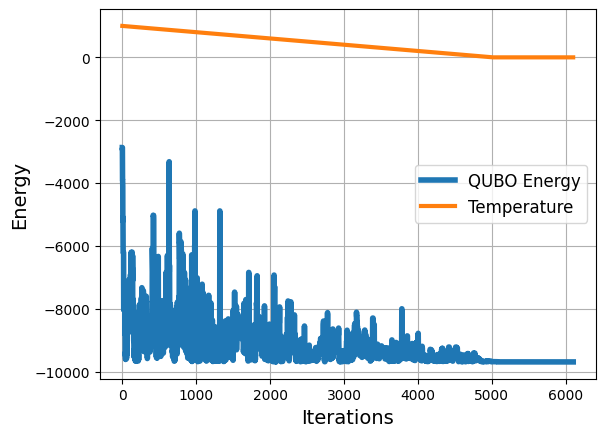

In [67]:
import matplotlib.pyplot as plt
eplt = res.energies

# fig, ax1 = plt.subplots()

left, bottom, width, height = [0.55, 0.55, 0.3, 0.3]

plt.plot(res.energies[:], lw=4, label="QUBO Energy")
plt.plot(Tschedule, lw=3, label='Temperature')
# ax1.axline((0, 0), slope=e, color="black", lw=4, linestyle=(4, (1, 2)))
plt.grid(which='both')
# plt.yscale('symlog')

plt.ylabel('Energy', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.legend(fontsize=12)

# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(eplt[-1000:])
# ax2.grid()
# ax2.axline((0, 0), slope=0, color="orange", linestyle=(1, (1, 2)))
# ax2.set_yscale('symlog')



In [68]:
idx_min = np.array([e for e in res.energies]).argmin()
# idx_min = -1
sol = res.trajectory[idx_min]
sol = designer.qubo.decode_solution(np.array(sol))
pipe_hot_encoding = sol[3]
sol = designer.combine_flow_values(sol)
sol = designer.convert_solution_to_si(sol)
sol = sol[:4]
print(sol)

[ 0.088  0.069 29.28  28.8  ]


In [69]:
designer.get_pipe_info_from_hot_encoding(pipe_hot_encoding)

(0.33815821889033915, array([500., 500.]))

Text(0.5, 1.0, 'Pressure')

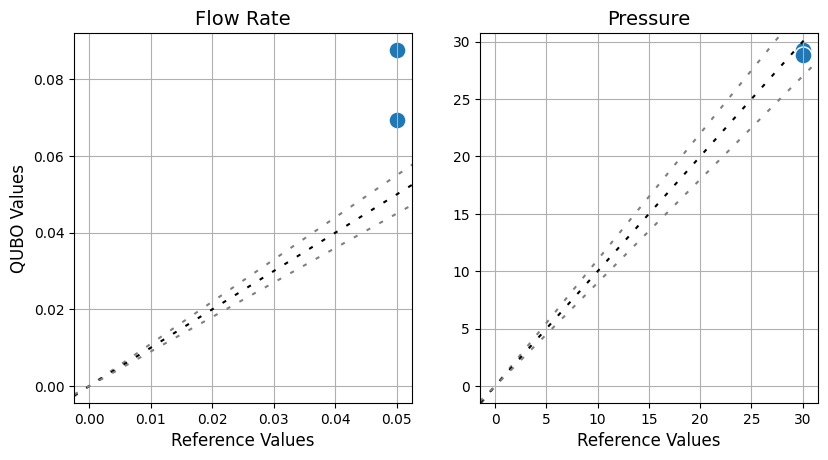

In [70]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = plt.figaspect(0.5))
ax1 = fig.add_subplot(121)

ax1.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))
ax1.grid()

# ax1.scatter(ref_values[:2], encoded_ref_sol[:2], c='black', s=200, label='Best solution')
ax1.scatter(ref_values[:2], sol[:2], s=150, lw=1, edgecolors='w', label='Sampled solution')


ax1.set_xlabel('Reference Values', fontsize=12)
ax1.set_ylabel('QUBO Values', fontsize=12)
ax1.set_title('Flow Rate', fontsize=14)

ax2 = fig.add_subplot(122)

ax2.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))


# ax2.scatter(ref_values[2:], encoded_ref_sol[2:], c='black', s=200, label='Best solution')
ax2.scatter(ref_values[2:], sol[2:], s=150, lw=1, edgecolors='w', label='Sampled solution')
ax2.grid()


ax2.set_xlabel('Reference Values', fontsize=12)
ax2.set_title('Pressure', fontsize=14)

# Old sampler

In [71]:
# from dwave.samplers import SimulatedAnnealingSampler
# options = {'sampler': SimulatedAnnealingSampler()}
# status = designer.solve(strength=1E8, num_reads=5000,  options=options)

In [72]:
# designer.total_pice

In [73]:
# designer.optimal_diameters

In [74]:
# designer.qubo.qubo_dict.num_variables

In [75]:
# import matplotlib.pyplot as plt
# plt.hist(designer.sampleset.data_vectors['energy'])